In [27]:
import os
import shutil

import csv
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
# import tensorflow_text as text
import keras

from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

#confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn



print(tf.__version__)

2.11.0


In [2]:
# #read data
# url = 'https://drive.google.com/file/d/16iYEWb1xCiuR5_TM47RVZyzLFwD7gZnT/view?usp=share_link'
# path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
# df = pd.read_csv(path)

In [3]:
# # # data.groupby('ipc_section').count()

# dataSort = df.query('(ipc_section == "A")').sample(n=1250)
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "B")').sample(n=1250)])
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "C")').sample(n=1250)])
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "D")').sample(n=1250)])
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "E")').sample(n=1250)])
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "F")').sample(n=1250)])
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "G")').sample(n=1250)])
# dataSort = pd.concat([dataSort,df.query('(ipc_section == "H")').sample(n=1250)])
# #shuffle data
# data = dataSort.sample(frac=1)

In [4]:
data = pd.read_csv("../data/patent-10k_balanced.csv")
data = data.sample(frac=1)

In [5]:
data.groupby('ipc_section').count()

,Unnamed: 0,application_number,kind_code,application_kind,family_id,language,title,abstract,ipc_code,ipc_class,ipc_code_sub_class
ipc_section,,,,,,,,,,,
A,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
B,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
C,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
D,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
E,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
F,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
G,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250
H,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250,1250


In [6]:
len(data)

10000

In [7]:
MAX_LEN = 512
MAX_TOKENS = 100000

preprocessing_layer = TextVectorization(
    # output_sequence_length=MAX_LEN, 
    # max_tokens=MAX_TOKENS
)
preprocessing_layer.adapt(data.abstract)

2023-02-16 16:23:24.562118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:23:24.574949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:23:24.576769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 16:23:24.579374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [8]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

41703

In [9]:
#one hot encode target
# classes = [[0,1,2,3,4,5,6,7][source] for source in dataSort.ipc_section]
classes = [{"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6,"H":7}[source] for source in data.ipc_section]
target = to_categorical(classes)
#print target
# target[2002]
len(target)

10000

In [18]:
BATCHSIZE = 5

inputs = Input(shape=(1,),dtype=tf.string,name="InputString")
x = preprocessing_layer(inputs)
# x = Embedding(VOCAB_SIZE+1,512,embeddings_regularizer=tf.keras.regularizers.L2(0.001))(x)
x = Embedding(VOCAB_SIZE+1,512)(x)
x = Lambda(lambda x:tf.reduce_mean(x,axis=1))(x)
# x = Dense(512,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.005))(inputs)
# x = Dense(512,activation="relu")(inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(8,activation="softmax")(x)

model = keras.Model(inputs=inputs,outputs=outputs,name="modeltest")
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["Accuracy"])

Model: "modeltest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputString (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 512)         21352448  
                                                                 
 lambda_3 (Lambda)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 21,356,552
Trainable params: 21,356,552
Non-trainable params: 0
_____________________________________________

In [19]:
modelhistory = model.fit(
    data.abstract,
    target, 
    epochs=20,
    batch_size=BATCHSIZE, 
    validation_split=0.2
    # validation_data=(data.text[6000:],target[6000:]),
    # callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/20
1600/1600 [==============================] - 45s 27ms/step - loss: 1.6334 - Accuracy: 0.4256 - val_loss: 1.3016 - val_Accuracy: 0.5535
Epoch 2/20
1600/1600 [==============================] - 17s 10ms/step - loss: 0.9590 - Accuracy: 0.6970 - val_loss: 1.1594 - val_Accuracy: 0.6025
Epoch 3/20
1600/1600 [==============================] - 14s 9ms/step - loss: 0.5712 - Accuracy: 0.8431 - val_loss: 1.1863 - val_Accuracy: 0.5980
Epoch 4/20
1600/1600 [==============================] - 13s 8ms/step - loss: 0.3286 - Accuracy: 0.9224 - val_loss: 1.2709 - val_Accuracy: 0.6075
Epoch 5/20
1600/1600 [==============================] - 14s 9ms/step - loss: 0.1841 - Accuracy: 0.9660 - val_loss: 1.4233 - val_Accuracy: 0.5925
Epoch 6/20
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1040 - Accuracy: 0.9835 - val_loss: 1.5680 - val_Accuracy: 0.5910
Epoch 7/20
1600/1600 [==============================] - 14s 8ms/step - loss: 0.0575 - Accuracy: 0.9942 - val_loss: 1.7693 - val_

<AxesSubplot:title={'center':'BS=5 | USE | 0.2 DO| 256 dense'}>

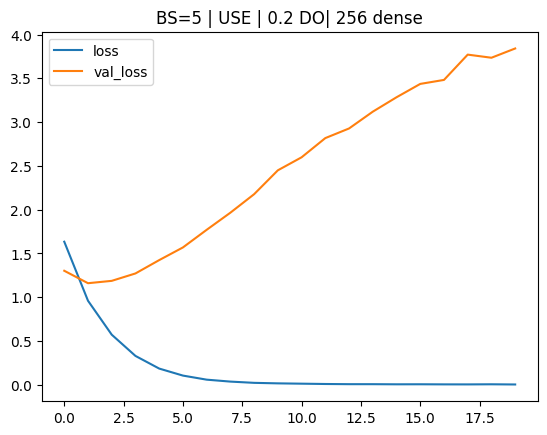

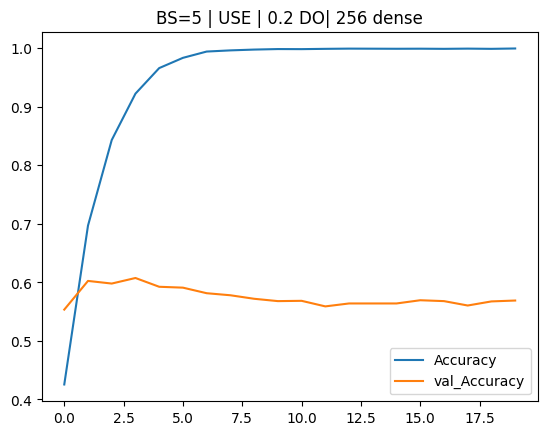

In [20]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]].plot(title="BS="+ str(BATCHSIZE) +" | USE | 0.2 DO| 256 dense")
pd.DataFrame(modelhistory.history)[["Accuracy","val_Accuracy"]].plot(title="BS="+ str(BATCHSIZE) +" | USE | 0.2 DO| 256 dense")

In [21]:
yhat_probs = model.predict(data.abstract, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
y_test_classes = np.argmax(target, axis=1)
matrix = confusion_matrix(y_test_classes, yhat_classes, normalize="true")
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCDEFGH"],
                     columns = [i for i in "ABCDEFGH"])
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)